# Home Credit Default Risk by Kaggle

Inspired by the classic Kaggle problem: [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/overview), we are creating an ultimate cheatsheet for data scientist interviews. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline  
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from utils import save_best_model, model_performance
import json
import joblib
import shap


set_config(transform_output="pandas") 

C:\Users\xinxin\venvs\ml311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
raw_data = pd.read_csv("data/application_train.csv")
previous_applications = pd.read_csv("etl/previous_applications_agg.csv")

In [3]:
df = raw_data.copy()
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df = df.merge(previous_applications, on="SK_ID_CURR", how="left", suffixes=["_main", "_previous_app"])

# 1. Check the target column

In [5]:
# 1. Check target value
df.groupby("TARGET").size()

TARGET
0    282686
1     24825
dtype: int64

In [6]:
df.drop(columns = ["TARGET", "SK_ID_CURR"], inplace=True)
trans_values = {}
col_transformers = []

This is a very **imbalanced data**, with label 1 less than 10% of label 0.
The way we usually handle imbalance data:

a) Data level:
Collect more data in minority class  
Undersample: might remove important data  
Oversample: might overfit  
To mitigate:   
Two-phase learning: train on resampled data, fine tune on original data  
Dynamic sampling: oversample the low-performing class and undersample the high performing class during training.  

b) Metric level: Check precision/recall, f1, AUC in ROC curve

c) Algorithm level: Add stronger penalty on misclassifying the minority class in loss function

# 2. Check predictors


2.0 Check the dtypes of predictors  
2.1 Check if all the numeric binary columns are in [0, 1]  
2.2 Check outliers in non-binary numeric cols, and impute them with null, medium or mean

In [7]:
# 2. Check the predictors
df.dtypes.value_counts()

float64    85
int64      39
object     16
Name: count, dtype: int64

In [8]:
num_cols = df.select_dtypes(include='number').columns.tolist()
num_cols = [_ for _ in num_cols if _ not in ["SK_ID_CURR", "TARGET"]]
print(len(num_cols))

124


In [9]:
num_cols_nonbinary = [x for x in num_cols if all(words not in x for words in ["FLAG", "NOT"])]
print(len(num_cols_nonbinary))
num_cols_binary = [_ for _ in num_cols if _ not in num_cols_nonbinary]
print(len(num_cols_binary))

92
32


In [10]:
# 2.1 Check if all the numeric binary columns are either 0 or 1
invalid_cols = df[num_cols_binary].columns[~df[num_cols_binary].isin([0,1]).all()]
print(invalid_cols)
# Looks good!

Index([], dtype='object')


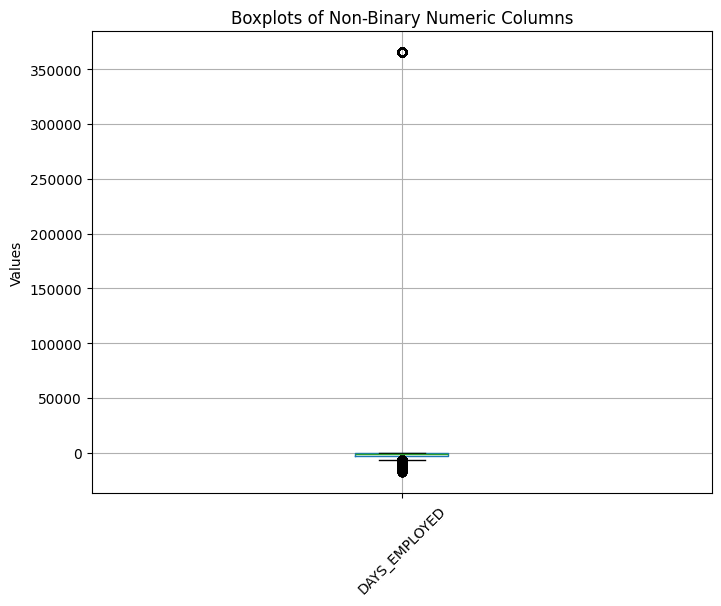

In [11]:
# 2.2 Check outliers on non-binary numeric cols

# Plot boxplots for the specified columns
plt.figure(figsize=(8, 6))
df[["DAYS_EMPLOYED"]].boxplot()
plt.title("Boxplots of Non-Binary Numeric Columns")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.show()

**How to deal with outliers?**

1. Remove the row
2. Impute with mean/medium/null value

In [12]:
# Drop the row
# index = df.loc[df['DAYS_EMPLOYED'].isna(), :].index
# df.drop(index, axis=0, inplace=True)


In [13]:
df["DAYS_EMPLOYED"].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [14]:
# Impute with null value
DAYS_EMPLOYED_UPPER = df['DAYS_EMPLOYED'].quantile(0.99)
print("DAYS_EMPLOYED_UPPER: ", DAYS_EMPLOYED_UPPER)

trans_values.update({'DAYS_EMPLOYED_UPPER': DAYS_EMPLOYED_UPPER})

# df.loc[df['DAYS_EMPLOYED'] >= DAYS_EMPLOYED_UPPER, 'DAYS_EMPLOYED'] = np.nan
# df.loc[df['DAYS_EMPLOYED'] > trans_values['DAYS_EMPLOYED_UPPER'], "DAYS_EMPLOYED"] = np.nan

DAYS_EMPLOYED_UPPER:  365243.0


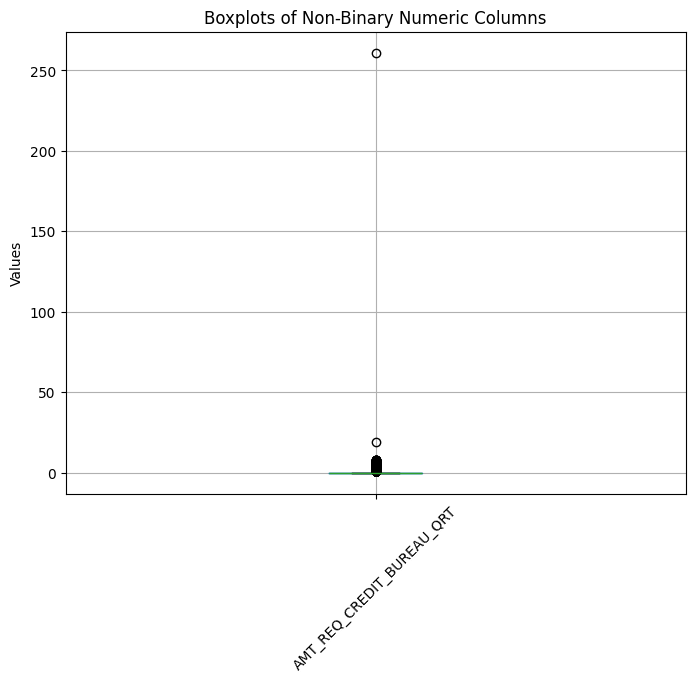

In [15]:
# Plot boxplots for the specified columns
plt.figure(figsize=(8, 6))
df[["AMT_REQ_CREDIT_BUREAU_QRT"]].boxplot()
plt.title("Boxplots of Non-Binary Numeric Columns")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.show()

In [16]:
df['AMT_REQ_CREDIT_BUREAU_QRT'].describe()

count    265992.000000
mean          0.265474
std           0.794056
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         261.000000
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: float64

In [17]:
# Impute with median

AMT_REQ_CREDIT_BUREAU_QRT_UPPER = 260 # From the plot
print("AMT_REQ_CREDIT_BUREAU_QRT_UPPER:  ", AMT_REQ_CREDIT_BUREAU_QRT_UPPER)

AMT_REQ_CREDIT_BUREAU_QRT_MEDIAN = df['AMT_REQ_CREDIT_BUREAU_QRT'].median()
print("AMT_REQ_CREDIT_BUREAU_QRT_MEDIAN: ", AMT_REQ_CREDIT_BUREAU_QRT_MEDIAN)


trans_values.update({'AMT_REQ_CREDIT_BUREAU_QRT_MEDIAN': AMT_REQ_CREDIT_BUREAU_QRT_MEDIAN,
                     'AMT_REQ_CREDIT_BUREAU_QRT_UPPER': AMT_REQ_CREDIT_BUREAU_QRT_UPPER
                    }
                   )

# df.loc[df['AMT_REQ_CREDIT_BUREAU_QRT'] > AMT_REQ_CREDIT_BUREAU_QRT_UPPER,'AMT_REQ_CREDIT_BUREAU_QRT'] = df['AMT_REQ_CREDIT_BUREAU_QRT'].median()

AMT_REQ_CREDIT_BUREAU_QRT_UPPER:   260
AMT_REQ_CREDIT_BUREAU_QRT_MEDIAN:  0.0


**Note!** In real-life ML practice, we always use the **training data only** for imputation or outlier detection. We can not foresee the stats of future unseen data in practice, and using test data would cause data leakage.  
In a Kaggle competition, however, we use train+test stats as it generally improves leaderboard score, but it won't generalize well outside the leaderboard.  
This notebook is for data scientist interview prep, so we always stick to real-life practice. The stats from training data are stored in a dictionary and will be applied to test data later.




# 3. Missing values in predictors

**Tree-based models**, like XGBoost, can handle missing values and no need to inpute.  
**Distance-based models**, linear Regression, SVM, KNN, Neural networks need imputation.


## 3.1 Impute Categorical Variables

If missing values < 5%:  impute with the mode.  
If missing values >= 5%:  impute with a new category in "Unknown" to indicate the value is missing


In [18]:
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols_missing_pct = df[cat_cols].isnull().sum()/df.shape[0]

In [19]:
# mising value percentage <= 5% -> most frequest
missing_minor_cols = cat_cols_missing_pct[(cat_cols_missing_pct <= 0.05) & (cat_cols_missing_pct > 0)].index.to_list()
df[missing_minor_cols].value_counts(dropna= False)

print("There are {} categorical columns with less than 5% missing vals: {}".format(len(missing_minor_cols), missing_minor_cols))




There are 1 categorical columns with less than 5% missing vals: ['NAME_TYPE_SUITE']


In [20]:
# mising value percentage > 5% -> "Unknown"
missing_major_cols = cat_cols_missing_pct[cat_cols_missing_pct > 0.05].index.to_list()
print("There are {} categorical columns with over 5% missing vals: {}".format(len(missing_major_cols), missing_major_cols))

There are 5 categorical columns with over 5% missing vals: ['OCCUPATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


## 3.2 Impute Numeric Variables


If missing values < 5%:  impute with the median.  
If missing values >= 5%:  impute with mean + missing flag column

In [21]:
num_cols_missing_pct = df[num_cols].isnull().sum()/df.shape[0]


In [22]:
num_cols_missing_minor_cols = num_cols_missing_pct[num_cols_missing_pct <=0.05].index.to_list()
print("There are {} numeric columns with less than 5% missing vals: {}".format(len(num_cols_missing_minor_cols), num_cols_missing_minor_cols))



# col_transformers.append(transform_minor_num_columns_pipe)

num_cols_missing_major_cols = num_cols_missing_pct[num_cols_missing_pct > 0.05].index.to_list()
print("There are {} numeric columns with over 5% missing vals: {}".format(len(num_cols_missing_major_cols), num_cols_missing_major_cols))



There are 52 numeric columns with less than 5% missing vals: ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13

# 4. Feature Engineering

## 4.1 One-hot vector

In real pipeline, we use SimpleImputer to avoid dataleakage.

# 5. Modeling

In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, confusion_matrix, precision_recall_curve
from outlier_and_nan_imputer import OutlierAndNaNImputer



In [24]:
# Prepare features

Y = raw_data["TARGET"]
X_cols = [_ for _ in df.columns if _ not in ["TARGET", "SK_ID_CURR"]]
X = df[X_cols]


DAYS_EMPLOYED and AMT_REQ_CREDIT_BUREAU_QRT need special treatment:

DAYS_EMPLOYED:
1. Identify values > 0.99 quantile as outliers, and impute with median.
2. Impute missing values with mean.

AMT_REQ_CREDIT_BUREAU_QRT:
1. Identify values > 260 as outliers, and impute with median.
2. Impute missing values with mean.

In [25]:
days_emp_pipe = Pipeline([
    ("days_employed", OutlierAndNaNImputer(q=0.99))
])

    
amt_req_qtr_pipe = Pipeline([
    ("imp", OutlierAndNaNImputer(upper=260))
])




num_minor_pipe = Pipeline([
    ("num_minor", SimpleImputer(strategy = "median")),
    ("scale", StandardScaler()),
    ("pca", PCA(n_components=0.99))
]
)

num_major_pipe = Pipeline([
    ("num_major", SimpleImputer(strategy = "mean", add_indicator=True)),
    ("scale", StandardScaler()),
    ("pca", PCA(n_components=0.99))
]
)

other_num_cols_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("pca", PCA(n_components=0.99))
]
)



cat_minor_pipe = Pipeline([
    ("cat_minor", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
]
)


cat_major_pipe = Pipeline([
    ("cat_major", SimpleImputer(strategy="constant", fill_value = "Unknown")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
]
)


other_cat_cols_pipline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
]
)


# Other column transformers
num_cols_missing_major_cols = [_ for _ in num_cols_missing_major_cols if _ not in ("DAYS_EMPLOYED", "AMT_REQ_CREDIT_BUREAU_QRT")]

special_num_cols = set(num_cols_missing_minor_cols+ num_cols_missing_major_cols+ ["DAYS_EMPLOYED", "AMT_REQ_CREDIT_BUREAU_QRT"])
other_num_cols = [_ for _ in num_cols if _ not in special_num_cols]

other_cat_cols = [_ for _ in cat_cols if (_ not in missing_minor_cols) and (_ not in missing_major_cols)]



col_transformers = [
    ("days_emp", days_emp_pipe, ["DAYS_EMPLOYED"]),
    ("amt_req_qtr", amt_req_qtr_pipe, ["AMT_REQ_CREDIT_BUREAU_QRT"]),
    ("num_minor", num_minor_pipe, num_cols_missing_minor_cols),
    ("num_major", num_major_pipe, num_cols_missing_major_cols),
    ("other_num", other_num_cols_pipe, other_num_cols),
    ("cat_minor", cat_minor_pipe, missing_minor_cols),
    ("cat_major", cat_major_pipe, missing_major_cols),
    ("other_cat", other_cat_cols_pipline, other_cat_cols)
    
]

preprocessor = ColumnTransformer(transformers= col_transformers, remainder="passthrough" )#.set_output(transform="pandas") 


# Split train-validation first, before fitting the column transformer
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.2, random_state=0)

In [ ]:
# Skip the hyper param tuning
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(
        solver="liblinear",
        random_state=0,
        max_iter=1000,
        C=0.1,
        penalty="l1",
        class_weight="balanced"
    ))
])

# Fit on the entire training set
pipe.fit(X_train, y_train)



loaded_model = pipe
y_pred = loaded_model.predict(X_test)
y_pred_prob = loaded_model.predict_proba(X_test)[:, 1]


# Print model performance
model_performance(y_test, y_pred, y_pred_prob)

In [30]:
# ### Hyperparam Tuning

# pipe = Pipeline(steps=[
#     ("preprocessor", preprocessor),
#     # ("smote", SMOTE(sampling_strategy=4/6, k_neighbors=3, random_state=0)),
#     ("clf", LogisticRegression(solver="liblinear", random_state=0, max_iter=1000))
# ])


# param_grid = {
#     "clf__C": [0.1],
#     "clf__penalty": ["l1"],
#     "clf__class_weight": ["balanced"]   # let CV choose
# }


# cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
# grid = GridSearchCV(
#     pipe,
#     param_grid,
#     scoring="roc_auc", 
#     cv=cv,
#     n_jobs=-1,
#     verbose=10,
#     refit=True
# )

# grid.fit(X_train, y_train)
# print("Best params:", grid.best_params_)
# print("CV AUC:", grid.best_score_)

# # Save the best model
# save_best_model(grid, "model/logreg_best_model.pkl")


# # Load model
# loaded_model = joblib.load("model/logreg_best_model.pkl")
# y_pred = loaded_model.predict(X_test)
# y_pred_prob = loaded_model.predict_proba(X_test)[:, 1]

# # Print model performance
# model_performance(y_test, y_pred, y_pred_prob)

The roc-auc score is fine but f1-score is low. One possible reason is the default threshold 0.5 didn't cutoff properly.

# Submit

In [33]:
raw_test_data = pd.read_csv("data/application_test.csv")


In [35]:
test_data = raw_test_data.merge(previous_applications, on="SK_ID_CURR", how="left", suffixes=["_main", "_previous_app"])

In [36]:
test_y_pred_prob = loaded_model.predict_proba(test_data)[:, 1]

# test_y_pred = best_param.predict(test_df_imputed)
# test_y_pred_prob = best_param.predict_proba(test_df_imputed)[:, 1]


final = pd.DataFrame(test_data[["SK_ID_CURR"]])
final["TARGET"] = test_y_pred_prob

final.to_csv("submission_lr.csv", index=False, header=True)

This version got a 0.74 AUC score

# Shapley Values

C:\Users\xinxin\venvs\ml311\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


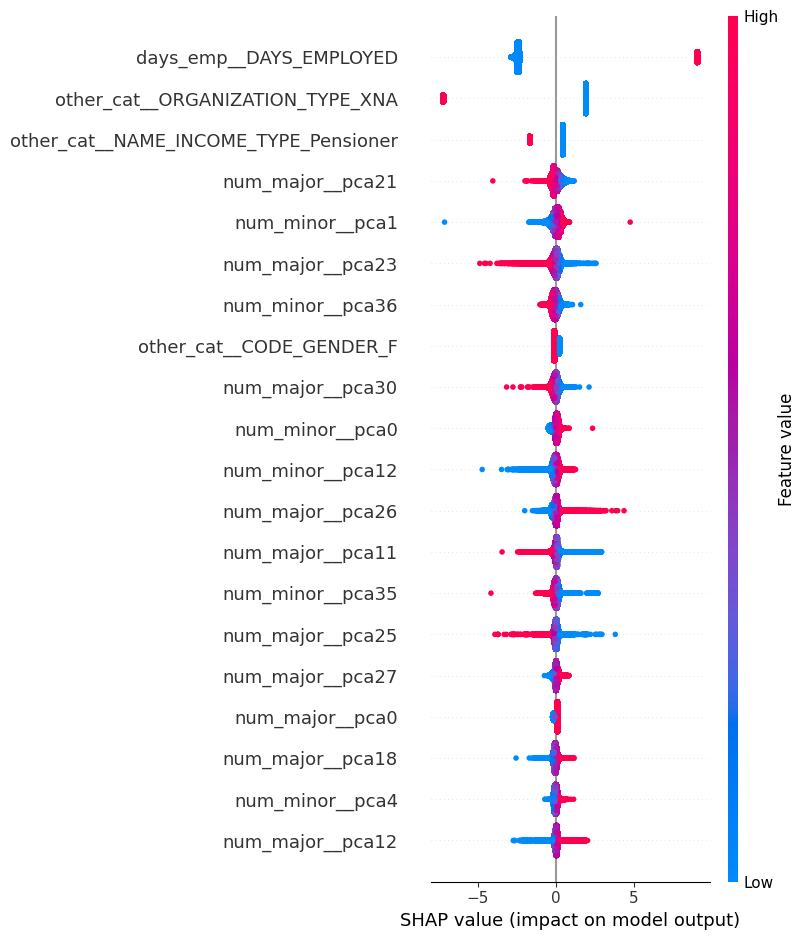

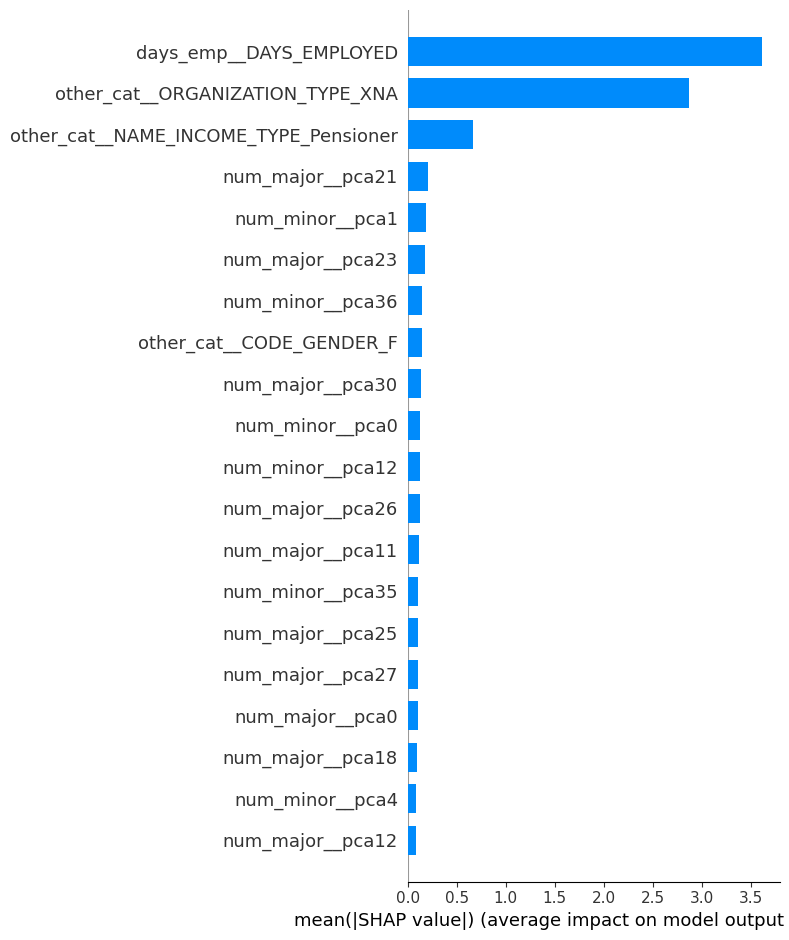

In [37]:

# 1) Split the pipeline
pre = loaded_model.named_steps["preprocessor"]
clf = loaded_model.named_steps["clf"]

# 2) Transform X with the (already-fitted) preprocessor
X_train_tr = pre.transform(X_train)

# 3) Optional: build a DataFrame for nicer plots (feature names are tricky; see note below)
# If you have a reliable way to get feature names, set columns=feat_names.
X_train_tr_df = pd.DataFrame(X_train_tr)

# 4) Explain the linear model on transformed features
explainer = shap.LinearExplainer(clf, X_train_tr, feature_perturbation="interventional")
shap_values = explainer(X_train_tr)

# 5) Plot
shap.summary_plot(shap_values, X_train_tr_df)
shap.summary_plot(shap_values, X_train_tr_df, plot_type="bar")